In [ ]:
!pip uninstall -y transformers huggingface_hub peft accelerate sentence-transformers
!pip install transformers==4.36.2 huggingface_hub==0.20.3 accelerate==0.25.0 peft==0.7.1
import os; os.kill(os.getpid(), 9)

  Using cached transformers-4.36.2-py3-none-any.whl.metadata (126 kB)
  Using cached huggingface_hub-0.20.3-py3-none-any.whl.metadata (12 kB)
  Using cached accelerate-0.25.0-py3-none-any.whl.metadata (18 kB)
  Using cached peft-0.7.1-py3-none-any.whl.metadata (25 kB)
  Using cached tokenizers-0.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
Using cached transformers-4.36.2-py3-none-any.whl (8.2 MB)
Using cached huggingface_hub-0.20.3-py3-none-any.whl (330 kB)
Using cached accelerate-0.25.0-py3-none-any.whl (265 kB)
Using cached peft-0.7.1-py3-none-any.whl (168 kB)
Using cached tokenizers-0.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.6 MB)
Usin

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 27.0 MB/s eta 0:00:00


In [ ]:
# Import required libraries: PyTorch, Pandas, sklearn for metrics and data splitting,
# Huggingface for model and tokenization,
# Optuna — for hyperparameter tuning

import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback
)
import optuna

# Load positive and negative reviews from Excel files
pos = pd.read_excel("pos_reviews.xlsx")
neg = pd.read_excel("neg_reviews.xlsx")

# Drop unnecessary columns and rename 'grade' to 'label'
pos = pos.drop(columns=['rating', 'course_id']).rename(columns={'grade': 'label'})
neg = neg.drop(columns=['rating', 'course_id']).rename(columns={'grade': 'label'})

# Combine both dataframes and shuffle the dataset
df = pd.concat([pos, neg]).sample(frac=1, random_state=42).reset_index(drop=True)

print(df.head())


/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


                                              review  label
0  Очень поверхностное влаение инструментами у пр...      0
1  На сайте не увидел обратной связи. Написать ав...      0
2  В целом, довольно неплохо. Мне, как человеку, ...      1
3  Качественное обучение. Информация воспринимает...      1
4  Курс очень интересный! Автору - моё почтение. ...      1


In [ ]:
# Display the total number of reviews and the label distribution (0 — negative, 1 — positive)

total = len(df)
print(f"Всего отзывов: {total}")

label_counts = df['label'].value_counts()
print("Количество Негативных (0) / Позитивных (1) отзывов:")
print(label_counts)

Всего отзывов: 320
Количество Негативных (0) / Позитивных (1) отзывов:
label
0    160
1    160
Name: count, dtype: int64


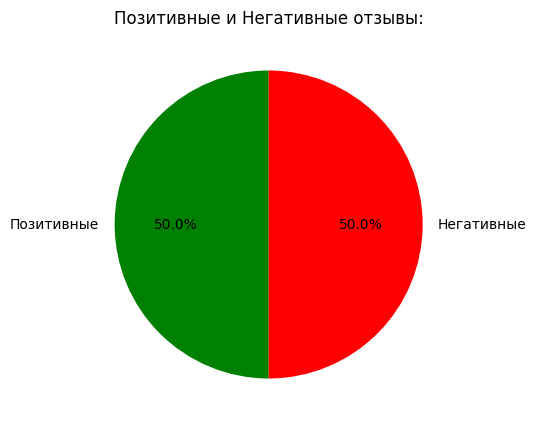

In [ ]:
# Create a pie chart to visualize the distribution of positive and negative reviews

import matplotlib.pyplot as plt

# Count reviews by label
label_counts = df['label'].value_counts()
labels = ['Позитивные', 'Негативные']
counts = [label_counts[1], label_counts[0]]

# Pie chart
plt.figure(figsize=(5, 5))
plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=['green', 'red'], startangle=90)
plt.title("Позитивные и Негативные отзывы:")
plt.show()


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")  # Load the RuBERT tokenizer for Russian text preprocessing

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Максимальная длина отзыва: 66
Средняя длина: 31.44


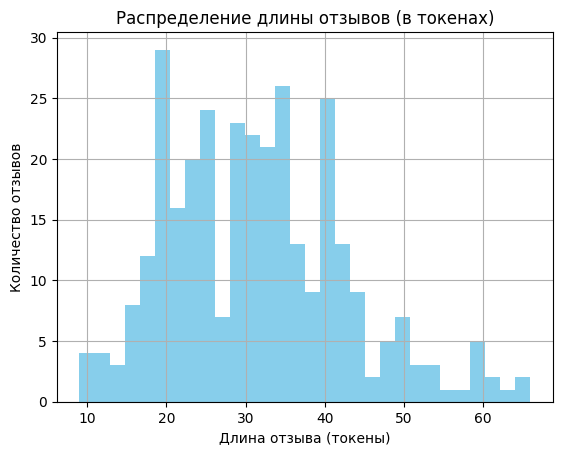

In [ ]:
# Tokenize each review and count its length (in tokens)
# Plot a histogram of the length distribution

import matplotlib.pyplot as plt

# Count the length of each review in tokens
token_lengths = [len(tokenizer.encode(text, add_special_tokens=True)) for text in df['review']]

# Display statistics
print(f"Максимальная длина отзыва: {max(token_lengths)}")
print(f"Средняя длина: {sum(token_lengths) / len(token_lengths):.2f}")

# Plot the distribution
plt.hist(token_lengths, bins=30, color='skyblue')
plt.title("Распределение длины отзывов (в токенах)")
plt.xlabel("Длина отзыва (токены)")
plt.ylabel("Количество отзывов")
plt.grid(True)
plt.show()


In [ ]:
texts = df['review'].tolist()
labels = df['label'].tolist()

# Split reviews into training (70%), validation (15%), and test (15%) sets while preserving label proportions

train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    texts, labels, test_size=0.3, stratify=labels, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

MAX_LENGTH = 72

# Function for tokenizing text with truncation to max_length and padding
def tokenize(texts):
    return tokenizer(texts, truncation=True, padding=True, max_length=MAX_LENGTH)

# Tokenize all three subsets
train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)
test_encodings = tokenize(test_texts)

# Create a custom PyTorch Dataset class to return tokens and labels for each entry
class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = ReviewDataset(train_encodings, train_labels)
val_dataset = ReviewDataset(val_encodings, val_labels)
test_dataset = ReviewDataset(test_encodings, test_labels)


In [ ]:

from transformers import PrinterCallback

In [ ]:
# Function to compute metrics
# Used during model training to evaluate performance on validation set
def compute_metrics(pred):
    labels = pred.label_ids                         # True class labels
    preds = pred.predictions.argmax(-1)             # Model predictions: select class with highest probability
    return {
        'accuracy': accuracy_score(labels, preds),  # Accuracy: proportion of correct predictions
        'f1': f1_score(labels, preds),              # F1-score: harmonic mean of precision and recall
        'precision': precision_score(labels, preds),# Precision: proportion of true positive predictions
        'recall': recall_score(labels, preds)       # Recall: proportion of actual positives correctly identified
    }

# Model initialization
# Creates a RuBERT model for binary classification (2 classes)
def model_init():
    return AutoModelForSequenceClassification.from_pretrained("DeepPavlov/rubert-base-cased", num_labels=2)

# Hyperparameter search space for Optuna
def optuna_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e-4, log=True),   # Learning rate
        "num_train_epochs": trial.suggest_int("num_train_epochs", 3, 6),              # Number of epochs
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),  # Batch size
        "seed": trial.suggest_int("seed", 1, 50),                                     # Random seed
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.3)                # Weight decay for regularization
    }

# Target metric for Optuna — F1 on validation ===
def compute_objective(metrics):
    return metrics["eval_f1"]

# Training arguments used during hyperparameter search
base_args = TrainingArguments(
    output_dir="./optuna_results",               # Folder to save results
    evaluation_strategy="epoch",                 # Evaluate after each epoch
    save_strategy="epoch",                       # Save model after each epoch
    load_best_model_at_end=True,                 # Load the best model based on the metric
    metric_for_best_model="eval_f1",             # Key metric — F1
    greater_is_better=True,                      # Higher F1 is better
    logging_dir="./logs",                        # Log folder
    report_to="none",                            # Do not report to external systems
    per_device_eval_batch_size=8                 # Batch size for validation
)

# Trainer for hyperparameter tuning using Optuna
trainer = Trainer(
    model_init=model_init,                       # Model is initialized fresh for each trial
    args=base_args,                              # Training arguments
    train_dataset=train_dataset,                 # Training dataset
    eval_dataset=val_dataset,                    # Validation dataset
    compute_metrics=compute_metrics,             # Metric computation function
)

# Start hyperparameter search (10 trials)
best_run = trainer.hyperparameter_search(
    direction="maximize",                        # Maximize F1
    hp_space=optuna_hp_space,                    # Search space
    compute_objective=compute_objective,         # Function to extract F1
    n_trials=10                                  # Number of trials
)

# Final training with best hyperparameters
print("best hyperparameters:", best_run.hyperparameters)  # Display best-found parameters

# Training arguments for the final model
final_args = TrainingArguments(
    output_dir="./best_model",                   # Folder to save the best model
    evaluation_strategy="epoch",                 # Evaluate each epoch
    save_strategy="epoch",                       # Save each epoch
    load_best_model_at_end=True,                 # Load the best model
    metric_for_best_model="eval_f1",             # F1 is the key metric
    greater_is_better=True,
    logging_dir="./logs-final",                  # Final training logs
    logging_strategy="steps",                    # Log every N steps
    logging_steps=10,                            # Logging frequency
    report_to="none",
    remove_unused_columns=False,                 # Do not remove extra columns (otherwise train_loss might not appear)
    disable_tqdm=False,                          # Show progress bar
    learning_rate=best_run.hyperparameters['learning_rate'],                   # Use best hyperparameters
    per_device_train_batch_size=best_run.hyperparameters['per_device_train_batch_size'],
    per_device_eval_batch_size=8,
    num_train_epochs=best_run.hyperparameters['num_train_epochs'],
    seed=best_run.hyperparameters['seed'],
    weight_decay=best_run.hyperparameters['weight_decay']
)

# Final Trainer with training and logging
final_trainer = Trainer(
    model=model_init(),                          # Initialize model
    args=final_args,                             # Training arguments
    train_dataset=train_dataset,                 # Training dataset
    eval_dataset=val_dataset,                    # Validation dataset
    compute_metrics=compute_metrics,             # Metrics
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=2),  # Early stopping (if metric doesn't improve for 2 epochs)
        PrinterCallback()                                   # Show training losses (train_loss)
    ]
)

# Start final training
final_trainer.train()

# Evaluate model on the test set
test_metrics = final_trainer.evaluate(test_dataset)
print("Тестовые метрики:", test_metrics)  # Display metrics: loss, accuracy, f1, etc.


/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-06-24 11:32:03,906] A new study created in memory with name: no-name-69a46707-63a0-48af-b13e-cb6336a2fb26
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.691998,0.500000,0.000000,0.000000,0.000000
2,No log,0.602793,0.729167,0.628571,1.000000,0.458333
3,No log,0.372239,0.916667,0.909091,1.000000,0.833333
4,No log,0.412345,0.895833,0.888889,0.952381,0.833333
5,No log,0.394199,0.895833,0.893617,0.913043,0.875000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2025-06-24 11:34:39,166] Trial 0 finished with value: 0.8936170212765957 and parameters: {'learning_rate': 8.661797544640537e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 8, 'seed': 18, 'weight_decay': 0.16130816076620785}. Best is trial 0 with value: 0.8936170212765957.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.355198,0.916667,0.916667,0.916667,0.916667
2,No log,0.297612,0.895833,0.888889,0.952381,0.833333
3,No log,0.192165,0.937500,0.938776,0.920000,0.958333
4,No log,0.158573,0.958333,0.958333,0.958333,0.958333
5,No log,0.158507,0.958333,0.958333,0.958333,0.958333


[I 2025-06-24 11:36:59,502] Trial 1 finished with value: 0.9583333333333334 and parameters: {'learning_rate': 5.147093397545464e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'seed': 41, 'weight_decay': 0.1415893024901492}. Best is trial 1 with value: 0.9583333333333334.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.363132,0.875000,0.857143,1.000000,0.750000
2,No log,0.309231,0.895833,0.883721,1.000000,0.791667
3,No log,0.248208,0.916667,0.909091,1.000000,0.833333
4,No log,0.414758,0.895833,0.883721,1.000000,0.791667
5,No log,0.323278,0.937500,0.933333,1.000000,0.875000


[I 2025-06-24 11:38:42,764] Trial 2 finished with value: 0.9333333333333333 and parameters: {'learning_rate': 3.0638702390587235e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 8, 'seed': 34, 'weight_decay': 0.1512374183644385}. Best is trial 1 with value: 0.9583333333333334.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.321694,0.875000,0.875000,0.875000,0.875000
2,No log,0.550214,0.833333,0.800000,1.000000,0.666667
3,No log,0.267266,0.937500,0.933333,1.000000,0.875000
4,No log,0.212458,0.958333,0.956522,1.000000,0.916667


[I 2025-06-24 11:40:02,638] Trial 3 finished with value: 0.9565217391304348 and parameters: {'learning_rate': 3.6033441242081825e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 8, 'seed': 21, 'weight_decay': 0.2753851018537944}. Best is trial 1 with value: 0.9583333333333334.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.452926,0.833333,0.846154,0.785714,0.916667
2,No log,0.762204,0.791667,0.736842,1.000000,0.583333
3,No log,0.319804,0.875000,0.857143,1.000000,0.750000


[I 2025-06-24 11:41:13,843] Trial 4 finished with value: 0.8571428571428571 and parameters: {'learning_rate': 6.57692382865894e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 8, 'seed': 24, 'weight_decay': 0.21984884409645522}. Best is trial 1 with value: 0.9583333333333334.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.309214,0.854167,0.837209,0.947368,0.750000


[I 2025-06-24 11:41:20,258] Trial 5 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.536386,0.750000,0.666667,1.000000,0.500000


[I 2025-06-24 11:41:26,365] Trial 6 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.681163,0.500000,0.000000,0.000000,0.000000
2,No log,0.640916,0.750000,0.684211,0.928571,0.541667


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2025-06-24 11:41:46,937] Trial 7 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.259157,0.916667,0.916667,0.916667,0.916667
2,No log,0.462291,0.916667,0.909091,1.000000,0.833333
3,No log,0.306700,0.916667,0.916667,0.916667,0.916667


[I 2025-06-24 11:42:54,529] Trial 8 finished with value: 0.9166666666666666 and parameters: {'learning_rate': 5.445513885524825e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 8, 'seed': 38, 'weight_decay': 0.23930268185711606}. Best is trial 1 with value: 0.9583333333333334.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.557186,0.812500,0.830189,0.758621,0.916667
2,No log,0.395142,0.895833,0.883721,1.000000,0.791667


[I 2025-06-24 11:43:17,087] Trial 9 pruned. 


best hyperparameters: {'learning_rate': 5.147093397545464e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'seed': 41, 'weight_decay': 0.1415893024901492}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.679300,0.748975,0.500000,0.000000,0.000000,0.000000
2,0.740800,0.464269,0.812500,0.780488,0.941176,0.666667
3,0.402200,0.341071,0.875000,0.857143,1.000000,0.750000
4,0.217600,0.401725,0.854167,0.829268,1.000000,0.708333
5,0.044900,0.286778,0.916667,0.909091,1.000000,0.833333


{'loss': 0.6793, 'learning_rate': 4.4117943407532546e-05, 'epoch': 0.71}
{'eval_loss': 0.7489749789237976, 'eval_accuracy': 0.5, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 0.2482, 'eval_samples_per_second': 193.378, 'eval_steps_per_second': 24.172, 'epoch': 1.0}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'loss': 0.7408, 'learning_rate': 3.676495283961046e-05, 'epoch': 1.43}
{'eval_loss': 0.4642692506313324, 'eval_accuracy': 0.8125, 'eval_f1': 0.7804878048780488, 'eval_precision': 0.9411764705882353, 'eval_recall': 0.6666666666666666, 'eval_runtime': 0.2415, 'eval_samples_per_second': 198.77, 'eval_steps_per_second': 24.846, 'epoch': 2.0}
{'loss': 0.5413, 'learning_rate': 2.9411962271688364e-05, 'epoch': 2.14}
{'loss': 0.4022, 'learning_rate': 2.2058971703766273e-05, 'epoch': 2.86}
{'eval_loss': 0.34107112884521484, 'eval_accuracy': 0.875, 'eval_f1': 0.8571428571428571, 'eval_precision': 1.0, 'eval_recall': 0.75, 'eval_runtime': 0.2485, 'eval_samples_per_second': 193.125, 'eval_steps_per_second': 24.141, 'epoch': 3.0}
{'loss': 0.2176, 'learning_rate': 1.4705981135844182e-05, 'epoch': 3.57}
{'eval_loss': 0.4017247259616852, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8292682926829268, 'eval_precision': 1.0, 'eval_recall': 0.7083333333333334, 'eval_runtime': 0.2464, 'eval_samples_p

{'eval_loss': 0.11585035175085068, 'eval_accuracy': 0.9791666666666666, 'eval_f1': 0.9787234042553191, 'eval_precision': 1.0, 'eval_recall': 0.9583333333333334, 'eval_runtime': 0.2677, 'eval_samples_per_second': 179.284, 'eval_steps_per_second': 22.411, 'epoch': 5.0}
Тестовые метрики: {'eval_loss': 0.11585035175085068, 'eval_accuracy': 0.9791666666666666, 'eval_f1': 0.9787234042553191, 'eval_precision': 1.0, 'eval_recall': 0.9583333333333334, 'eval_runtime': 0.2677, 'eval_samples_per_second': 179.284, 'eval_steps_per_second': 22.411, 'epoch': 5.0}


In [ ]:
import pandas as pd
from tabulate import tabulate  # Import function for nicely formatted table output in console

# Save final model metrics (on the test set) to a dictionary
metrics = {
    'Loss': test_metrics['eval_loss'],             # Test loss
    'Accuracy': test_metrics['eval_accuracy'],     # Accuracy
    'F1-score': test_metrics['eval_f1'],           # F1-score
    'Precision': test_metrics['eval_precision'],   # Precision
    'Recall': test_metrics['eval_recall']          # Recall
}

# Convert the dictionary to a DataFrame for better visualization
df = pd.DataFrame([metrics])

print(tabulate(df, headers='keys', tablefmt='fancy_grid', showindex=False))


╒═════════╤════════════╤════════════╤═════════════╤══════════╕
│    Loss │   Accuracy │   F1-score │   Precision │   Recall │
╞═════════╪════════════╪════════════╪═════════════╪══════════╡
│ 0.11585 │   0.979167 │   0.978723 │           1 │ 0.958333 │
╘═════════╧════════════╧════════════╧═════════════╧══════════╛


In [ ]:
import pandas as pd
from IPython.display import display  # Used for nicely formatted table display in Jupyter Notebook

# Extract best hyperparameters found by Optuna
best_params = best_run.hyperparameters

# Convert to a table: two columns — hyperparameter name and its value
df = pd.DataFrame(best_params.items(), columns=["Hyperparameter", "Value"])

display(df)

,Hyperparameter,Value
0,learning_rate,0.000051
1,num_train_epochs,5.000000
2,per_device_train_batch_size,16.000000
3,seed,41.000000
4,weight_decay,0.141589


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# Get model predictions on the test dataset
preds_output = final_trainer.predict(test_dataset)

# Extract true labels and predicted classes
y_true = preds_output.label_ids                                 # True labels
y_pred = np.argmax(preds_output.predictions, axis=1)            # Model predictions (choose class with highest probability)


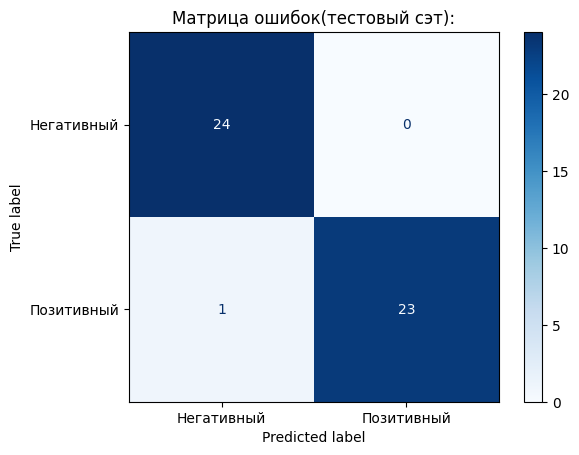

In [ ]:
# Build the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix as a diagram
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Негативный", "Позитивный"])
disp.plot(cmap=plt.cm.Blues)                                    # Color scheme: blue
plt.title("Матрица ошибок (тестовый сэт):")                     # Chart title
plt.grid(False)                                                 # Remove grid for cleaner display
plt.show()


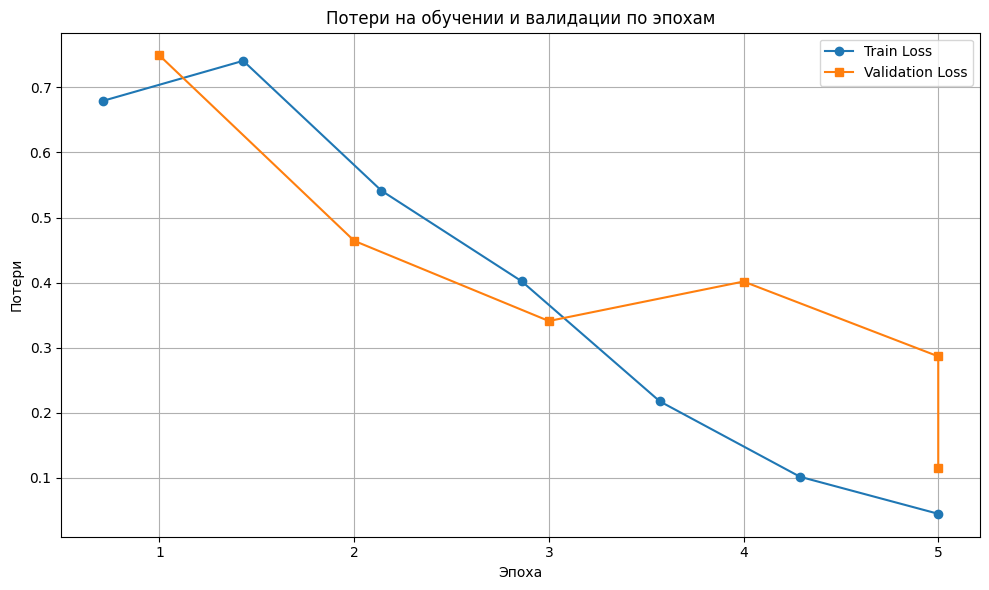

In [ ]:
# Extract log history
log_history = final_trainer.state.log_history

# Lists to store data
train_loss = []
eval_loss = []
epochs_train = []
epochs_eval = []

# Iterate through each log entry and extract train_loss and eval_loss
for log in log_history:
    if 'loss' in log and 'epoch' in log:
        train_loss.append(log['loss'])
        epochs_train.append(log['epoch'])
    if 'eval_loss' in log and 'epoch' in log:
        eval_loss.append(log['eval_loss'])
        epochs_eval.append(log['epoch'])

# Plotting the graph
plt.figure(figsize=(10, 6))
# Training loss line
plt.plot(epochs_train, train_loss, label='Train Loss', marker='o')
# Validation loss line
plt.plot(epochs_eval, eval_loss, label='Validation Loss', marker='s')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.title('Потери на обучении и валидации по эпохам')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


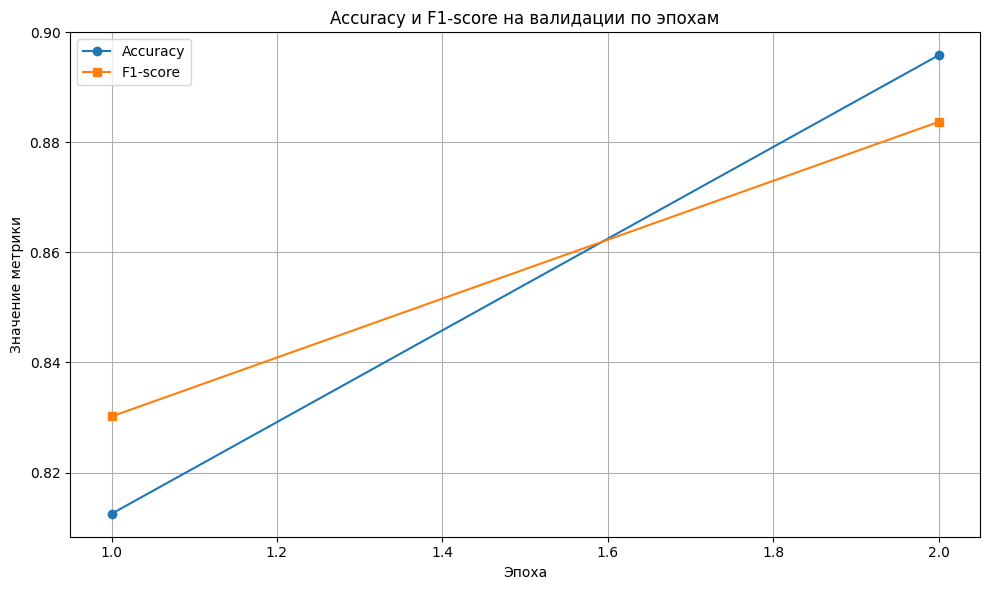

In [ ]:
# Collect metrics per epoch
epochs = []
accuracies = []
f1_scores = []

# Iterate through each log entry
# If the log contains 'eval_accuracy', it's a validation log — save the values
for log in log_history:
    if 'eval_accuracy' in log:
        epochs.append(log['epoch'])
        accuracies.append(log['eval_accuracy'])
        f1_scores.append(log['eval_f1'])

# Plot the graph
plt.figure(figsize=(10, 6))
# Accuracy line
plt.plot(epochs, accuracies, marker='o', label='Accuracy')
# F1-score line
plt.plot(epochs, f1_scores, marker='s', label='F1-score')
plt.xlabel('Эпоха')
plt.ylabel('Значение метрики')
plt.title('Accuracy и F1-score на валидации по эпохам')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
